In [12]:
# from src.download_dataset.download import *
#
# list_mode = ["ClassBMN"]
#
# for mode in list_mode:
#     download_data("MINI-DDSM", mode)
#
# for mode in list_mode:
#     download_data("MIAS", mode)

In [1]:
from src.utils.gpu import print_num_gpus_available

print_num_gpus_available()

Numero de GPU disponibles:  1
Dispositivo de GPU por defecto: /device:GPU:0


In [1]:
from src.settings import config
from src.utils.utils import *
import matplotlib.pyplot as plt
from src.parameters.image_parameters import *
from src.parameters.model_parameters import *
import tensorflow as tf

# --------------Configuraciones Iniciales---------------------------------
config.DEBUG_MODE = False
config.DEBUG_MODE_MODELS = True
config.SAVE_MODEL_COMPLETE_MLFlow = False
config.LOG_MODEL_MLFlow = False
config.LOG_JSON_TXT_MODEL_MLFlow = True
config.USE_DESCRIPTOR = True
# -------------Configuraciones del Pipeline--------
# mode_classification = "ClassBMN"
mode_classification = "Binary(BM)N"
folder_to_class = "Binary(BM)N_off_brint/"
dataset = "MIAS"
# dataset = "MIAS"
type_data = "data_aug"

width_shape = 224
height_shape = 224
# epochs = 2
epochs = 16
# batch_size = 3
batch_size = 64
# 'categorical'
class_mode = definite_class_mode(mode_classification)
# color_mode = definite_mode_read() #grayscale
# color_mode = 'rgb'  
color_mode = 'grayscale'
# --------------Parametros del Modelo para compilar----------
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, RMSprop
from tensorflow.keras.losses import sparse_categorical_crossentropy, categorical_crossentropy

#'binary_crossentropy' 'categorical_crossentropy'
loss = definition_loss(mode_classification)
# loss = definition_loss(mode_classification)
# loss = sparse_categorical_crossentropy
# loss = categorical_crossentropy

learning_rate = 1e-3
# learning_rate = 1e-5
optimizer = Adam(learning_rate=learning_rate)
# optimizer = RMSprop(learning_rate=learning_rate)
# Precision, Recall,CategoricalAccuracy
list_metric = get_list_metrics(mode_classification)
# validation_split = 0.2
validation_split = 0.2
print("Primeras configuraciones terminadas...")
path_to_classification = "data/" + type_data + "/" + dataset + "/" + folder_to_class
print(path_to_classification)

E:\anaconda3\envs\env_breast_cancer\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Primeras configuraciones terminadas...
data/data_aug/MIAS/Binary(BM)N_off_brint/


In [2]:
amount_images_to_classification(path_to_classification, mode_classification)
print("Carpeta de clasificación:", mode_classification)
print("epochs:", epochs)
print("batch size:", batch_size)
print("class mode:", class_mode)
print("color mode:", color_mode)
print("Loss:", loss)
print("optimizer:", str(optimizer))
print("Taza de aprendisaje:", learning_rate)
print("Metricas:", list(map(name_metric, list_metric)))
print("Porcentaje para validación:", validation_split)
print("Path de datos:", path_to_classification)
print("Fin de la configuración")

Tumoral: 20520
Normal: 21960
Carpeta de clasificación: Binary(BM)N
epochs: 16
batch size: 64
class mode: binary
color mode: grayscale
Loss: binary_crossentropy
optimizer: <keras.optimizer_v2.adam.Adam object at 0x000001EC4D7C3CA0>
Taza de aprendisaje: 0.001
Metricas: ['precision', 'recall', 'binary_accuracy']
Porcentaje para validación: 0.2
Path de datos: data/data_aug/MIAS/Binary(BM)N_off_brint/
Fin de la configuración


Found 33984 images belonging to 2 classes.
Found 8496 images belonging to 2 classes.
División de datos de entrenamiento y prueba completado
Shape Img del data gen: (128, 128, 1)
N dim: 3


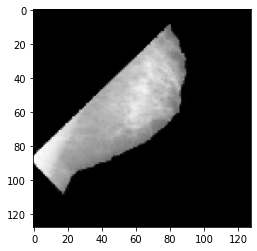

In [11]:
def show_imgs_titles(imgs, titles):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

    ax1.imshow(imgs[0], cmap='gray')
    ax1.set_title(titles[0])
    ax1.axis('off')

    ax2.imshow(imgs[1], cmap='gray')
    ax2.set_title(titles[1])
    ax2.axis('off')

    ax3.imshow(imgs[2], cmap='gray')
    ax3.set_title(titles[2])
    ax3.axis('off')

    plt.show()


datagen = ImageDataGenerator(
    # rescale=1. / 255,
    # dtype='uint8',
    fill_mode="nearest",
    validation_split=validation_split
)
batch_size_imgs = 1
data_gen_train = datagen.flow_from_directory(path_to_classification,
                                             batch_size=batch_size_imgs,
                                             class_mode=class_mode,  #save_to_dir='',
                                             subset='training',
                                             target_size=(128, 128),
                                             color_mode=color_mode)
data_gen_test = datagen.flow_from_directory(path_to_classification,
                                            batch_size=batch_size_imgs,
                                            target_size=(128, 128),
                                            class_mode=class_mode,
                                            subset='validation',
                                            color_mode=color_mode)
print("División de datos de entrenamiento y prueba completado")
#Imprimir 10 imagenes del generador de entrenamiento
x = data_gen_train.next()
# name_file = data_gen_train.filepaths
# print(name_file)
for i in range(0, 1):
    imagen = x[i][0]
    print("Shape Img del data gen:", imagen.shape)
    print("N dim:", imagen.ndim)
        
    # ------------Mostrar en rgb---------------
    # ? imagen -> 224 224 3
#     b, g, r = imagen[:, :, 0], imagen[:, :, 1], imagen[:, :, 2]
#     print(b.shape)
#     print(g.shape)
#     print(r.shape)
#     imgs = [b, g, r]
#     titles = ["Imagen Procesada", "Brint S", "Brint M"]
#     show_imgs_titles(imgs, titles)
    
    plt.imshow(imagen, cmap='gray')
#     plt.imshow(imagen)
    plt.show()
    
    # cv2.imwrite("ga1.tif", imagen)
    # cv2.imwrite("ga2.tif", r)
    # cv2.imwrite("ga3.tif", g)
    # cv2.imwrite("ga4.tif", b)

    # cv2.imshow('tif image',imagen)
    # cv2.waitKey(0)
    # ? Mostrar la imagen un camañ de formato .tif
    # Otros esquemas de color: cmap=plt.cm.Spectral or cmap=plt.cm.hot
    # https://stackoverflow.com/questions/34165941/how-to-display-tiff-file-in-color
    # plt.imshow(imagen[:, :, 0], cmap=plt.cm.coolwarm)

    # ? IMportante para verlo en color original como se guardo
    # plt.imshow(imagen.astype('uint8'))
   

    # break

In [9]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.activations import *
from keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from time import time


def create_model_simple():
    reg = tf.keras.regularizers.L2(l2=1e-5)
    ini = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=None)

    model = Sequential()
    model.add(Conv2D(32,
                     kernel_size=(3, 3),
                     activation='relu',
                     kernel_initializer=ini,
                     input_shape=(128, 128, 1)))
    model.add(Conv2D(64,
                     kernel_size=(3, 3),
                     kernel_initializer=ini,
                     activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(64,
                     kernel_size=(3, 3),
                     kernel_initializer=ini,
                     activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Dense(64,
                    kernel_initializer=ini,
                    activation='relu'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model


model = create_model_simple()
optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss=loss, metrics=list_metric)
# model.compile(optimizer=optimizer,
#               loss= 'binary_crossentropy',
#               metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
dense_2 (Dense)              (None, 30, 30, 64)       

In [5]:
from src.utils.utils import Save_model_summary_txt_architecture_json
from src.models.Models import create_model, transfer_learning

print("")
architectures_cnns = ["ResNet50", "VGG16", "CNN", "MobilNet2", "VGG19"]
name_red = "VGG16"  #"ResNet50" #--VGG16--CNN--MobilNet2--VGG19
model = create_model(name_model=name_red, mode_classification=mode_classification)
if config.LOG_JSON_TXT_MODEL_MLFlow:
    Save_model_summary_txt_architecture_json(model)
config.USE_DESCRIPTOR = True
print("Modelo creando .." + name_red)
model.compile(optimizer=optimizer, loss=loss, metrics=list_metric)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0    

In [17]:
# epochs = 25
# batch_size_red = 8
# !fit_generator esta obsoleto
from tensorflow.keras.callbacks import EarlyStopping

# es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1)

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True, verbose=1)

check_point_filepath = 'temp/'

model_check_point = ModelCheckpoint(filepath=check_point_filepath, monitor='val_loss', verbose=1, save_best_only=True,
                                    save_weights_only=False, mode='auto', save_freq='epoch')
epochs = 100
history = model.fit(
    data_gen_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,
    callbacks=[early_stop, model_check_point])

# if config.LOG_MODEL_MLFlow:
#     tf.keras.models.save_model(model, "temp/model/")

ValueError: `validation_split` is only supported for Tensors or NumPy arrays, found following types in the input: [<class 'keras.preprocessing.image.DirectoryIterator'>]

In [15]:
import mlflow
from mlflow.entities import Metric
from mlflow.tracking import MlflowClient

mlflow_client = MlflowClient()
EXPERIMENT_NAME = "MIAS_Brint_2_2_new_experiments"
try:
    EXPERIMENT_ID = mlflow.create_experiment(EXPERIMENT_NAME)
except:
    EXPERIMENT_ID = mlflow_client.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
name_red = "simple_CNN"
transfer_learning = False
with mlflow.start_run(experiment_id=EXPERIMENT_ID, run_name=name_red) as active_run:
    # with mlflow.start_run(run_name=name_red) as active_run:
    # mlflow_client = MlflowClient()
    # experiment_id = mlflow_client.create_experiment("Mamografías CNNs experimentos")
    # experiment_id = "0"
    # run = mlflow_client.create_run(experiment_id)
    all_metrics = []
    f1, val_f1 = get_F1_scores(history)
    for metric_name in history.history:
        for i in history.epoch:
            metric = Metric(
                key=metric_name,
                value=history.history[metric_name][i],
                timestamp=0,
                step=i,
            )
            all_metrics.append(metric)
    all_metrics = all_metrics + f1 + val_f1

    mlflow_client.log_batch(run_id=active_run.info.run_id, metrics=all_metrics)
    mlflow_client.log_param(run_id=active_run.info.run_id, key="batch size", value=batch_size)
    mlflow_client.log_param(run_id=active_run.info.run_id, key="learning rate", value=learning_rate)
    mlflow_client.log_param(run_id=active_run.info.run_id, key="epochs", value=epochs)
    mlflow_client.log_param(run_id=active_run.info.run_id, key="optimizer", value=optimizer.__class__.__name__)
    mlflow_client.log_param(run_id=active_run.info.run_id, key="Loss", value=loss)
    mlflow_client.log_param(run_id=active_run.info.run_id, key="DB", value=dataset)
    mlflow_client.log_param(run_id=active_run.info.run_id, key="Transfer Learning", value=transfer_learning)
    mlflow_client.log_param(run_id=active_run.info.run_id, key="Folder para clasificar", value=mode_classification)
    mlflow_client.log_param(run_id=active_run.info.run_id, key="Split test", value=validation_split)

    if config.LOG_JSON_TXT_MODEL_MLFlow:
        mlflow.log_artifact("temp/summary_model.txt", artifact_path="arquitectura")
        mlflow.log_artifact("temp/architecture.json", artifact_path="arquitectura")
    if config.LOG_MODEL_MLFlow:
        mlflow_client.log_artifacts(run_id=active_run.info.run_id, local_dir="temp/model/")

    mlflow_client.log_batch(run_id=active_run.info.run_id, metrics=all_metrics)
    print("Todas las metricas guardadas")
# ?Guardar las metricas por cada epoca
# tags = {'Transfer Learning:': transfer_learning}
# mlflow_client.set_experiment_tag(0, "name DB", dataset)

Todas las metricas guardadas


In [24]:
# mlflow.end_run()
# print("Se detuvo MLFlow")

In [25]:
# acc = history.history['categorical_accuracy']
# val_acc = history.history['val_categorical_accuracy']
#
# loss = history.history['loss']
# val_loss = history.history['val_loss']
#
# rango_epocas = range(epochs)
#
# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(rango_epocas, acc, label='accuracy Entrenamiento')
# plt.plot(rango_epocas, val_acc, label='accuracy Pruebas')
# plt.legend(loc='lower right')
# plt.title('Precisión de entrenamiento y pruebas')
#
# plt.subplot(1, 2, 2)
# plt.plot(rango_epocas, loss, label='Pérdida de entrenamiento')
# plt.plot(rango_epocas, val_loss, label='Pérdida de pruebas')
# plt.legend(loc='upper right')
# plt.title('Pérdida de entrenamiento y pruebas')
# plt.show()

In [26]:
# import pandas as pd
#
# column_values = ['accuracy de train',
#                  'accuracy de pruebas',
#                  'perdida de train',
#                  'perdida de pruebas']
# array = list(zip(acc, val_acc, loss, val_loss))
# df = pd.DataFrame(data=array, columns=column_values)
# df
# df.describe()
